# **noisOut:** Denoising Diffusion Probabilistic Models

In [1]:
import os

import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

### Dataset Investigation

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 458kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.03MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.99MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



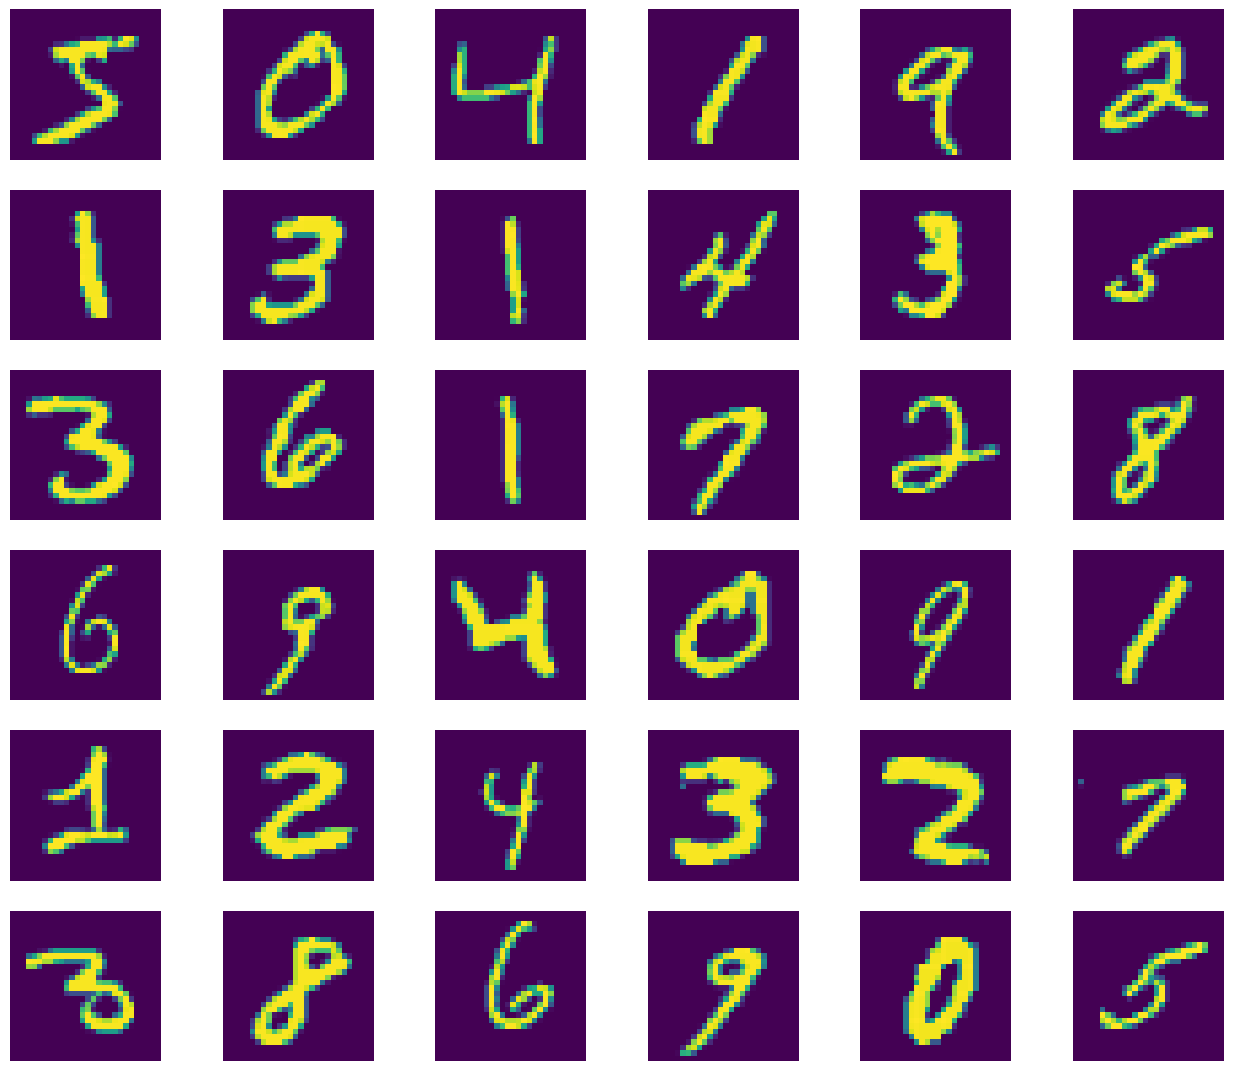

In [2]:
def show_images(dataset, num_samples=36, cols=6):
    rows = num_samples//cols + 1

    plt.figure(figsize=(16, 16))
    for i in range(num_samples):
        image, target = dataset[i]
        image = image.permute(1, 2, 0)
        image = image.numpy()
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

dataset = torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True)
show_images(dataset)

In [3]:
IMG_SIZE = 16
BATCH_SIZE = 16

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

In [5]:
def load_transformed_dataset():
    data_transforms = [
        torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.ToTensor(),                  # [ 0, 1]
        torchvision.transforms.Lambda(lambda t: t*2 - 1)    # [-1, 1]
    ]

    data_transform = torchvision.transforms.Compose(data_transforms)

    train = torchvision.datasets.MNIST('./data', download=True, transform=data_transform, train=True)
    test = torchvision.datasets.MNIST('./data', download=True, transform=data_transform, train=False)

    return torch.utils.data.ConcatDataset([train, test])

def load_reverse_transformed_dataset(images):
    reverse_transforms = [
        torchvision.transforms.Lambda(lambda t: (t+1) / 2), # [0, 1]
        torchvision.transforms.ToPILImage()
    ]

    reverse_transform = torchvision.transforms.Compose(reverse_transforms)

    return reverse_transform(images[0])

def show_images(pictures):
    num_pictures = len(pictures)
    fig, axes = plt.subplots(1, num_pictures, figsize=(num_pictures * 2, 2))

    if num_pictures == 1:
        axes = [axes]

    for idx, image in enumerate(pictures):
        ax = axes[idx]
        ax.imshow(image.permute(1, 2, 0).cpu().numpy() if isinstance(image, torch.Tensor) else image)
        ax.axis('off')

    plt.show()

In [6]:
dataset = load_transformed_dataset()
dataloader = torch.utils.data.DataLoader(dataset, BATCH_SIZE, shuffle=True, drop_last=True)
dataloader

### **Diffusion Closed Form**

In [7]:
def beta_schedule(time_steps, start=0.0001, end=0.02, device='cpu'):
    return torch.linspace(start, end, time_steps, device=device)

T = 1000

betas = beta_schedule(T, device=device)
betas_cumprod = torch.cumprod(betas, 0)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, 0)

sqrt_alphas = torch.sqrt(alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)

sqrt_betas = torch.sqrt(betas)
sqrt_betas_cumprod = torch.sqrt(betas_cumprod)

one_minus_alphas_cumprod = 1. - alphas_cumprod
one_minus_betas_cumprod = 1. - betas_cumprod

sqrt_one_minus_alphas_cumprod = torch.sqrt(one_minus_alphas_cumprod)
sqrt_one_minus_betas_cumprod = torch.sqrt(one_minus_betas_cumprod)

variance = torch.zeros(T, device=device)
variance[1:] = betas[1:] * one_minus_alphas_cumprod[:-1] / one_minus_alphas_cumprod[1:]

In [8]:
next(iter(dataloader))[0].numpy()   # (B, C, H, W)

array([[[[-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         ...,
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ]]],


       [[[-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         ...,
         [-1.        , -1.      

In [9]:
next(iter(dataloader))[1].numpy()   # (B, C, H, W)

array([8, 2, 3, 5, 2, 6, 1, 9, 9, 0, 8, 1, 9, 4, 6, 3])

### **The Forward Pass**

In [10]:
def forward_diffusion(x_0, t, device='cpu'):
    B, C, H, W = x_0.shape

    noise = torch.randn_like(x_0, device=device)

    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, *[1]*(len(x_0.shape)-1))
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, *[1]*(len(x_0.shape)-1))

    x_0 = x_0.to(device)
    noise = noise.to(device)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t.to(device)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod_t.to(device)

    # re-parameterization trick
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

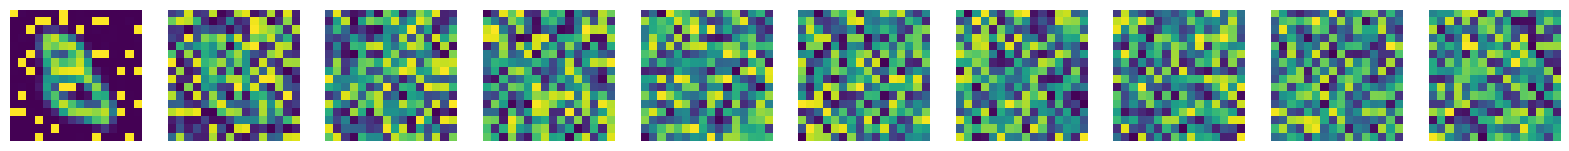

In [11]:
batch = next(iter(dataloader))
batch_images = batch[0]
batch_labels = batch[1]

num_images = 10
step_size = T // num_images

pictures = []
for idx, t in enumerate(range(0, T, step_size)):
    t = torch.tensor([t])
    images, noises = forward_diffusion(batch_images, t)
    image = load_reverse_transformed_dataset(images)
    pictures.append(image)

show_images(pictures)

### **The Backward Pass**

In [12]:
class SinusodialPositionEmbeddings(torch.nn.Module):

    def __init__(self, t_dim):
        super().__init__()
        self.t_dim = t_dim

    def forward(self, t):
        t_dim = self.t_dim                                      # [0, t_dim]
        h_dim = self.t_dim//2                                   # [0, t_dim/2]
        i = torch.arange(h_dim, device=t.device, dtype=t.dtype) # (h_dim, )
        i = i.unsqueeze(0)                                      # (1, h_dim)
        t = t.unsqueeze(-1)                                     # (t, 1)
        x = t / (1000 ** (2 * i / self.t_dim))                  # (t, h_dim)

        emb = torch.cat([torch.sin(x)[:, :, None], torch.cos(x)[:, :, None]], dim=-1)   # (t, h_dim*2)
        emb = emb.view(t.shape[0], self.t_dim)                                          # (t, t_dim)
        return emb

In [13]:
TIME_DIM = 1024
TIME_STEPS = 128

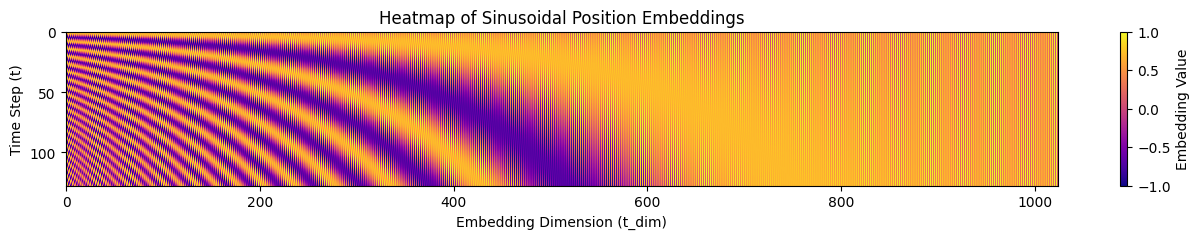

In [14]:
def show_heat_map(t_dim=TIME_DIM, t_steps=TIME_STEPS):
    embeddings = SinusodialPositionEmbeddings(t_dim)

    time_steps = torch.arange(0, t_steps)
    emb_matrix = embeddings(time_steps).detach().numpy()

    plt.figure(figsize=(16, 2))
    plt.imshow(emb_matrix, cmap='plasma', aspect='auto')
    plt.colorbar(label='Embedding Value')
    plt.title('Heatmap of Sinusoidal Position Embeddings')
    plt.xlabel('Embedding Dimension (t_dim)')
    plt.ylabel('Time Step (t)')
    plt.show();

show_heat_map(TIME_DIM, TIME_STEPS)

In [15]:
class Block(torch.nn.Module):

    def __init__(self, channels_in, channels_out, t_dim, sampling):
        super().__init__()

        self.t_mlp = torch.nn.Linear(t_dim, channels_out)
        self.sampling = sampling

        if sampling == 'up':
            self.conv_1 = torch.nn.Conv2d(2 * channels_in, channels_out, kernel_size=3, stride=2, padding=1)
            self.transform = torch.nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1)
        if sampling == 'down':
            self.conv_1 = torch.nn.ConvTranspose2d(1 * channels_in, channels_out, kernel_size=3, stride=2, padding=1)
            self.transform = torch.nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1)
        self.bnorm_1 = torch.nn.BatchNorm2d(channels_out)

        self.conv_2 = torch.nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1)
        self.bnorm_2 = torch.nn.BatchNorm2d(channels_out)

        self.relu = torch.nn.ReLU()

    def forward(self, x, t):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.bnorm_1(x)

        t = self.t_mlp(t)
        t = t.view(t.shape[0], t.shape[1], 1, 1)

        x = x + t

        x = self.conv_2(x)
        x = self.relu(x)
        x = self.bnorm_2(x)

        x = self.transform(x)

        return x

In [16]:
class UNet(torch.nn.Module):

    def __init__(self, img_channels, t_dim):
        super().__init__()

        self.img_channels_in = img_channels
        self.img_channels_out = img_channels

        self.u_channels = (64, 128, 256, 512, 1024)
        self.d_channels = (1024, 512, 256, 128, 64)

        self.t_dim = t_dim

        self.t_mlp = torch.nn.Sequential(
            SinusodialPositionEmbeddings(self.t_dim),
            torch.nn.Linear(self.t_dim, self.t_dim),
            torch.nn.ReLU()
        )

        self.conv_in = torch.nn.Conv2d(self.img_channels_in, self.d_channels[0], kernel_size=3, stride=1, padding=1)

        self.d_sampling_blocks = torch.nn.ModuleList(
            [
                Block(self.d_channels[i], self.d_channels[i+1], t_dim, 'down')
                for i in range(len(self.d_channels)-1)
            ]
        )

        self.u_sampling_blocks = torch.nn.ModuleList(
            [
                Block(self.u_channels[i], self.u_channels[i+1], t_dim, 'up')
                for i in range(len(self.u_channels)-1)
            ]
        )

        self.conv_out = torch.nn.Conv2d(self.u_channels[-1], self.img_channels_out, kernel_size=3, stride=1, padding=1)

    def forward(self, x, t):
        t = self.t_mlp(t)

        x = self.conv_in(x)

        residual_blocks = []

        for d_block in self.d_sampling_blocks:
            x = d_block(x, t)                           # (B, C, H, W)
            residual_blocks.append(x)                   # (B, C, H, W)

        for u_block in self.u_sampling_blocks:
            r = residual_blocks.pop()                   # (B, C, H, W)
            x = u_block(torch.cat([x, r], dim=1), t)    # (B, C, H, W)

        x = self.conv_out(x)

        return x

In [17]:
CHANNEL_COUNT = 1

In [18]:
model = UNet(CHANNEL_COUNT, 32)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters()):,}')
model.to(device)
model

Number of parameters: 50,270,753


UNet(
  (t_mlp): Sequential(
    (0): SinusodialPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv_in): Conv2d(1, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (d_sampling_blocks): ModuleList(
    (0): Block(
      (t_mlp): Linear(in_features=32, out_features=512, bias=True)
      (conv_1): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (transform): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm_1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm_2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (t_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv_1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), paddi

### **Loss Function**

In [19]:
def calculate_loss(model, x_0, t):
    x_t, noise = forward_diffusion(x_0, t, device)

    x_t_ = model(x_t, t)

    loss = torch.nn.functional.mse_loss(x_t_, noise)
    return loss

### **Inference Sampling**

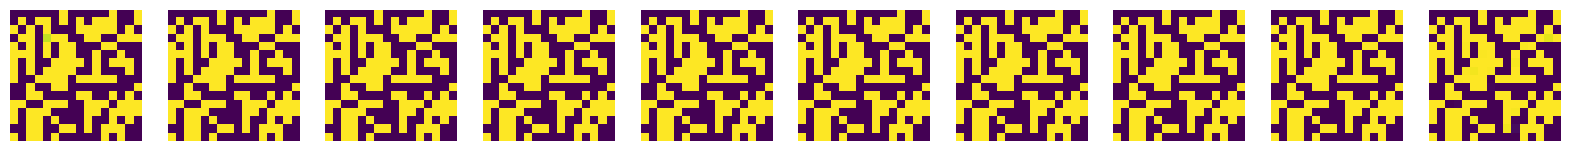

In [20]:
@torch.no_grad()
def sample_image():

    @torch.no_grad()
    def sample_tensor(x_t, t):
        noise_ = model(x_t, t)

        betas_t = betas[t].view(-1, *[1]*(len(x_t.shape)-1)).to(device)
        alphas_t = alphas[t].view(-1, *[1]*(len(x_t.shape)-1)).to(device)
        sqrt_betas_t = sqrt_betas[t].view(-1, *[1]*(len(x_t.shape)-1)).to(device)
        sqrt_alphas_t = sqrt_alphas_cumprod[t].view(-1, *[1]*(len(x_t.shape)-1)).to(device)
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, *[1]*(len(x_t.shape)-1)).to(device)

        mean_t = ((x_t / sqrt_alphas_t) - betas_t * noise_ / (sqrt_one_minus_alphas_cumprod_t * sqrt_alphas_t)).to(device)
        variance_t = variance[t].view(-1, *[1]*(len(x_t.shape)-1)).to(device)

        return mean_t if t == 0 else mean_t + (torch.sqrt(variance_t) * torch.randn_like(x_t, device=device))

    img_size = IMG_SIZE

    img = torch.randn((1, CHANNEL_COUNT, img_size, img_size), device=device)

    num_images = 10
    step_size = T // num_images

    pictures = []
    for idx, t in enumerate(range(T-1, -1, -step_size)):
        t = torch.tensor([t], device=device)
        img = sample_tensor(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        image = load_reverse_transformed_dataset(img)
        pictures.append(image)

    show_images(pictures)

sample_image()

### **Training Loop**

Epoch:    1 | Step:   10 | Loss: 0.657068
Epoch:    1 | Step:   20 | Loss: 0.314443
Epoch:    1 | Step:   30 | Loss: 0.404713
Epoch:    1 | Step:   40 | Loss: 0.237521
Epoch:    1 | Step:   50 | Loss: 0.328324
Epoch:    1 | Step:   60 | Loss: 0.234888
Epoch:    1 | Step:   70 | Loss: 0.196397
Epoch:    1 | Step:   80 | Loss: 0.234156
Epoch:    1 | Step:   90 | Loss: 0.232384
Epoch:    1 | Step:  100 | Loss: 0.268159


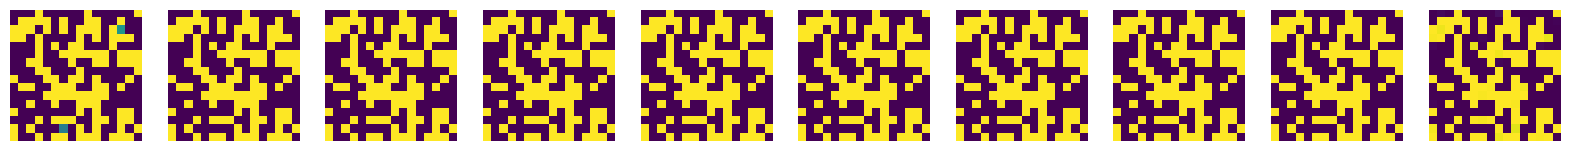

Epoch:    1 | Step:  110 | Loss: 0.267685
Epoch:    1 | Step:  120 | Loss: 0.318040
Epoch:    1 | Step:  130 | Loss: 0.191321
Epoch:    1 | Step:  140 | Loss: 0.293159
Epoch:    1 | Step:  150 | Loss: 0.306898
Epoch:    1 | Step:  160 | Loss: 0.236529
Epoch:    1 | Step:  170 | Loss: 0.214814
Epoch:    1 | Step:  180 | Loss: 0.184463
Epoch:    1 | Step:  190 | Loss: 0.203805
Epoch:    1 | Step:  200 | Loss: 0.205902


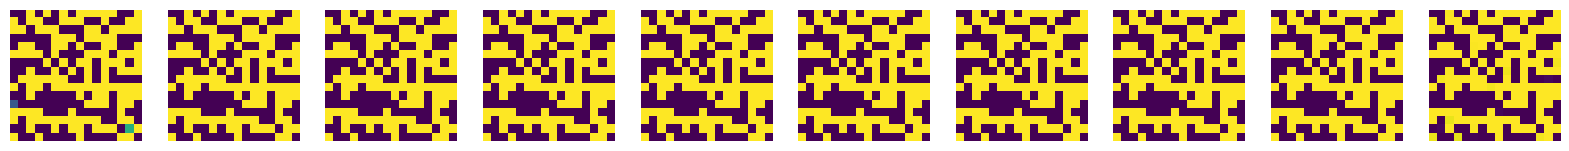

Epoch:    1 | Step:  210 | Loss: 0.155329
Epoch:    1 | Step:  220 | Loss: 0.146464
Epoch:    1 | Step:  230 | Loss: 0.223155
Epoch:    1 | Step:  240 | Loss: 0.213270
Epoch:    1 | Step:  250 | Loss: 0.196761
Epoch:    1 | Step:  260 | Loss: 0.173041
Epoch:    1 | Step:  270 | Loss: 0.173517
Epoch:    1 | Step:  280 | Loss: 0.183109
Epoch:    1 | Step:  290 | Loss: 0.181569
Epoch:    1 | Step:  300 | Loss: 0.132266


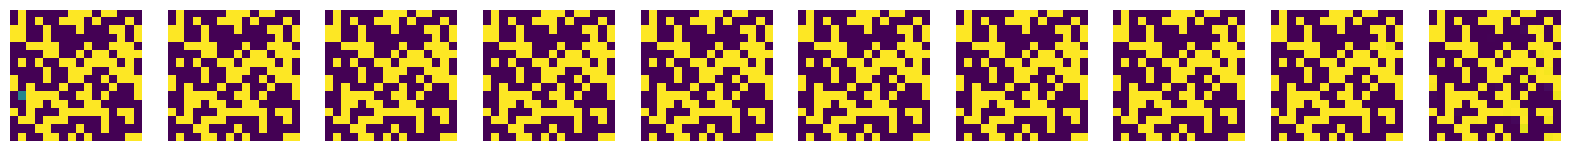

Epoch:    1 | Step:  310 | Loss: 0.124013
Epoch:    1 | Step:  320 | Loss: 0.260428
Epoch:    1 | Step:  330 | Loss: 0.150184
Epoch:    1 | Step:  340 | Loss: 0.150316
Epoch:    1 | Step:  350 | Loss: 0.143346
Epoch:    1 | Step:  360 | Loss: 0.190162
Epoch:    1 | Step:  370 | Loss: 0.196656
Epoch:    1 | Step:  380 | Loss: 0.129041
Epoch:    1 | Step:  390 | Loss: 0.189054
Epoch:    1 | Step:  400 | Loss: 0.155649


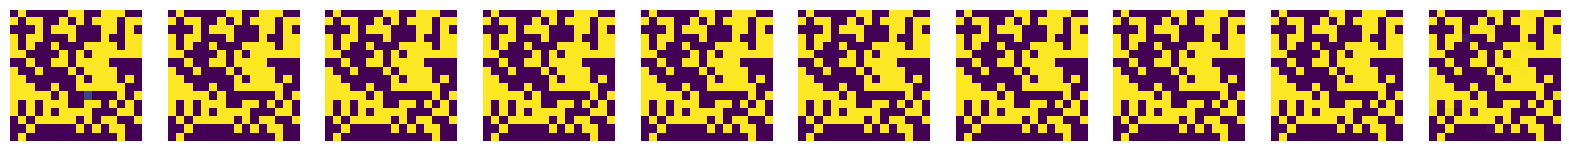

Epoch:    1 | Step:  410 | Loss: 0.106013
Epoch:    1 | Step:  420 | Loss: 0.142963
Epoch:    1 | Step:  430 | Loss: 0.174901
Epoch:    1 | Step:  440 | Loss: 0.109570
Epoch:    1 | Step:  450 | Loss: 0.115744
Epoch:    1 | Step:  460 | Loss: 0.154923
Epoch:    1 | Step:  470 | Loss: 0.134834
Epoch:    1 | Step:  480 | Loss: 0.112386
Epoch:    1 | Step:  490 | Loss: 0.145830
Epoch:    1 | Step:  500 | Loss: 0.118852


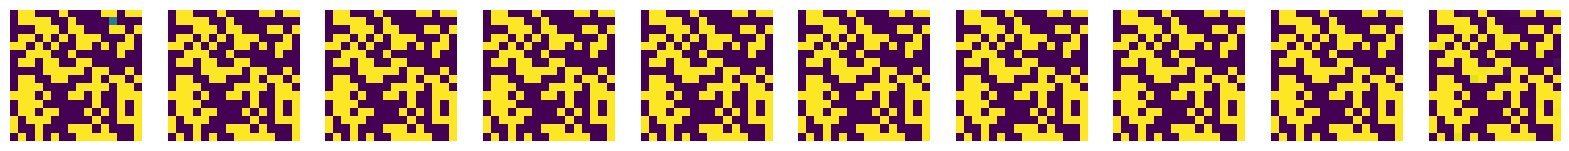

Epoch:    1 | Step:  510 | Loss: 0.161215
Epoch:    1 | Step:  520 | Loss: 0.139838
Epoch:    1 | Step:  530 | Loss: 0.130647
Epoch:    1 | Step:  540 | Loss: 0.163722
Epoch:    1 | Step:  550 | Loss: 0.108472
Epoch:    1 | Step:  560 | Loss: 0.106445
Epoch:    1 | Step:  570 | Loss: 0.137279
Epoch:    1 | Step:  580 | Loss: 0.152493
Epoch:    1 | Step:  590 | Loss: 0.108481
Epoch:    1 | Step:  600 | Loss: 0.119895


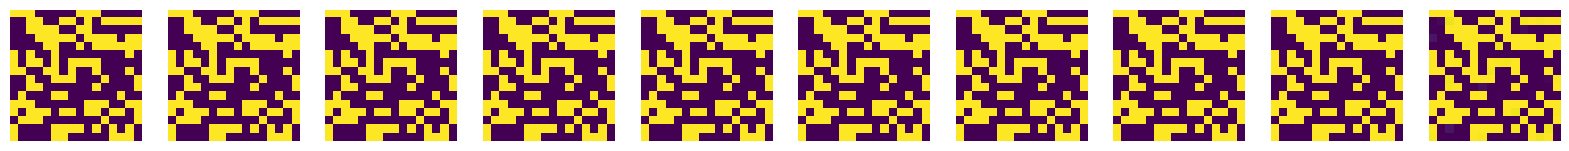

Epoch:    1 | Step:  610 | Loss: 0.163482
Epoch:    1 | Step:  620 | Loss: 0.133355
Epoch:    1 | Step:  630 | Loss: 0.114024
Epoch:    1 | Step:  640 | Loss: 0.082992
Epoch:    1 | Step:  650 | Loss: 0.174764
Epoch:    1 | Step:  660 | Loss: 0.098090
Epoch:    1 | Step:  670 | Loss: 0.083211
Epoch:    1 | Step:  680 | Loss: 0.177806
Epoch:    1 | Step:  690 | Loss: 0.097111
Epoch:    1 | Step:  700 | Loss: 0.097158


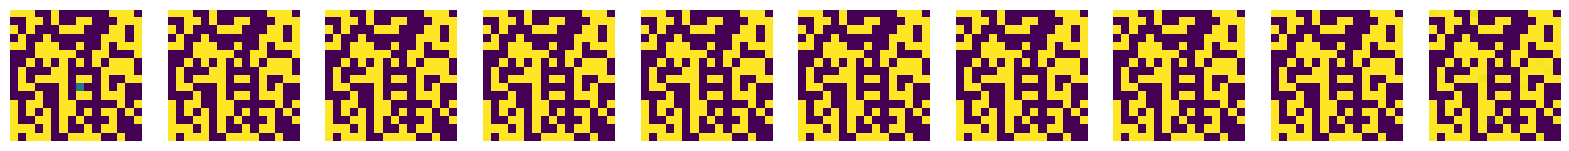

Epoch:    1 | Step:  710 | Loss: 0.127137
Epoch:    1 | Step:  720 | Loss: 0.082663
Epoch:    1 | Step:  730 | Loss: 0.132449
Epoch:    1 | Step:  740 | Loss: 0.104426
Epoch:    1 | Step:  750 | Loss: 0.130193
Epoch:    1 | Step:  760 | Loss: 0.111051
Epoch:    1 | Step:  770 | Loss: 0.124390
Epoch:    1 | Step:  780 | Loss: 0.076471
Epoch:    1 | Step:  790 | Loss: 0.090543
Epoch:    1 | Step:  800 | Loss: 0.144170


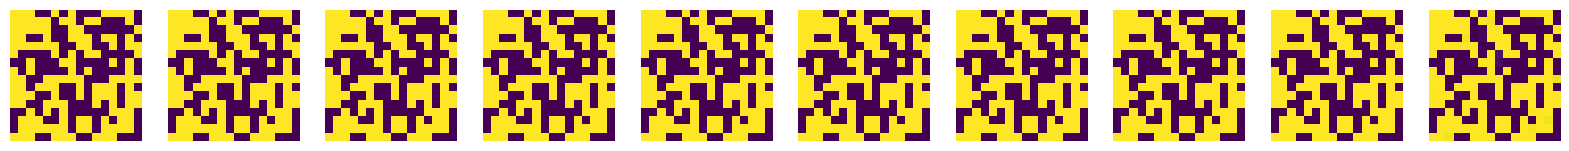

Epoch:    1 | Step:  810 | Loss: 0.133976
Epoch:    1 | Step:  820 | Loss: 0.123391
Epoch:    1 | Step:  830 | Loss: 0.137961
Epoch:    1 | Step:  840 | Loss: 0.106191
Epoch:    1 | Step:  850 | Loss: 0.091731
Epoch:    1 | Step:  860 | Loss: 0.109121
Epoch:    1 | Step:  870 | Loss: 0.161687
Epoch:    1 | Step:  880 | Loss: 0.081793
Epoch:    1 | Step:  890 | Loss: 0.084747
Epoch:    1 | Step:  900 | Loss: 0.097531


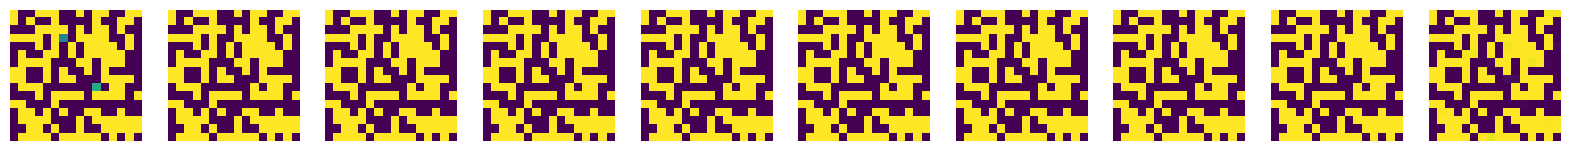

Epoch:    1 | Step:  910 | Loss: 0.091781
Epoch:    1 | Step:  920 | Loss: 0.057162
Epoch:    1 | Step:  930 | Loss: 0.155384
Epoch:    1 | Step:  940 | Loss: 0.137019
Epoch:    1 | Step:  950 | Loss: 0.085328
Epoch:    1 | Step:  960 | Loss: 0.133889
Epoch:    1 | Step:  970 | Loss: 0.088202
Epoch:    1 | Step:  980 | Loss: 0.131671
Epoch:    1 | Step:  990 | Loss: 0.100589
Epoch:    1 | Step: 1000 | Loss: 0.128907


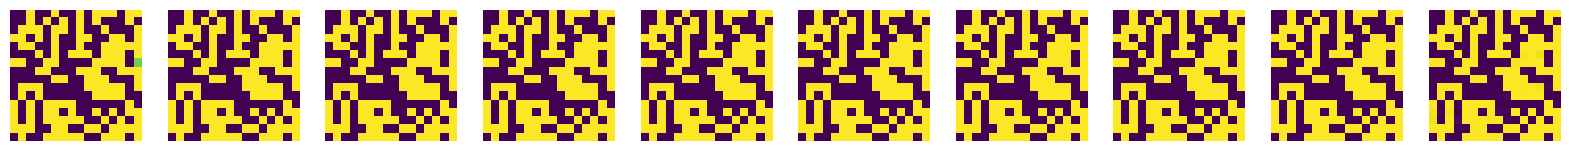

Epoch:    1 | Step: 1010 | Loss: 0.111172
Epoch:    1 | Step: 1020 | Loss: 0.145982
Epoch:    1 | Step: 1030 | Loss: 0.083490
Epoch:    1 | Step: 1040 | Loss: 0.078958
Epoch:    1 | Step: 1050 | Loss: 0.082765
Epoch:    1 | Step: 1060 | Loss: 0.087554
Epoch:    1 | Step: 1070 | Loss: 0.069497
Epoch:    1 | Step: 1080 | Loss: 0.103978
Epoch:    1 | Step: 1090 | Loss: 0.081290
Epoch:    1 | Step: 1100 | Loss: 0.124910


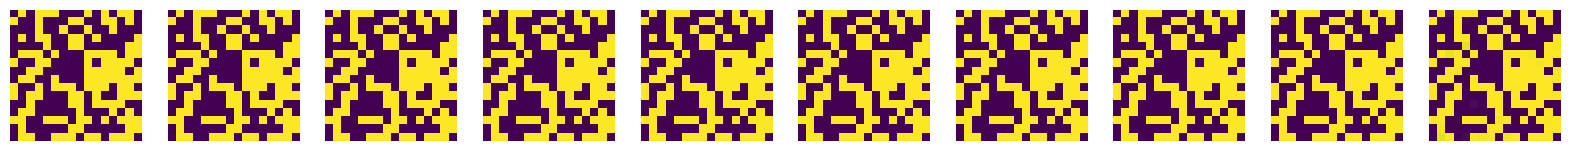

Epoch:    1 | Step: 1110 | Loss: 0.104260
Epoch:    1 | Step: 1120 | Loss: 0.092438
Epoch:    1 | Step: 1130 | Loss: 0.141535
Epoch:    1 | Step: 1140 | Loss: 0.056999
Epoch:    1 | Step: 1150 | Loss: 0.116787
Epoch:    1 | Step: 1160 | Loss: 0.086841
Epoch:    1 | Step: 1170 | Loss: 0.185217
Epoch:    1 | Step: 1180 | Loss: 0.152574
Epoch:    1 | Step: 1190 | Loss: 0.077427
Epoch:    1 | Step: 1200 | Loss: 0.095214


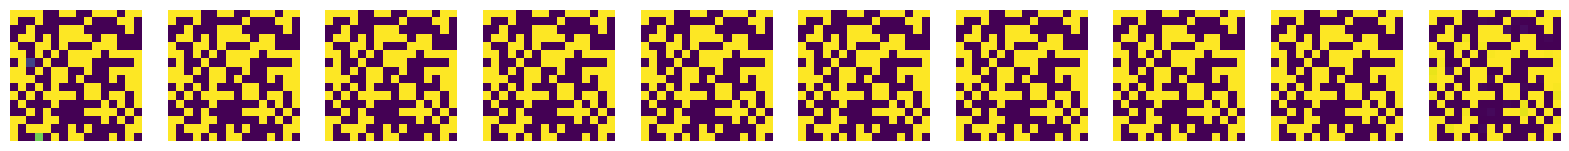

Epoch:    1 | Step: 1210 | Loss: 0.074237
Epoch:    1 | Step: 1220 | Loss: 0.118118
Epoch:    1 | Step: 1230 | Loss: 0.074442
Epoch:    1 | Step: 1240 | Loss: 0.119445
Epoch:    1 | Step: 1250 | Loss: 0.118140
Epoch:    1 | Step: 1260 | Loss: 0.110724
Epoch:    1 | Step: 1270 | Loss: 0.152743
Epoch:    1 | Step: 1280 | Loss: 0.100676
Epoch:    1 | Step: 1290 | Loss: 0.121380
Epoch:    1 | Step: 1300 | Loss: 0.071267


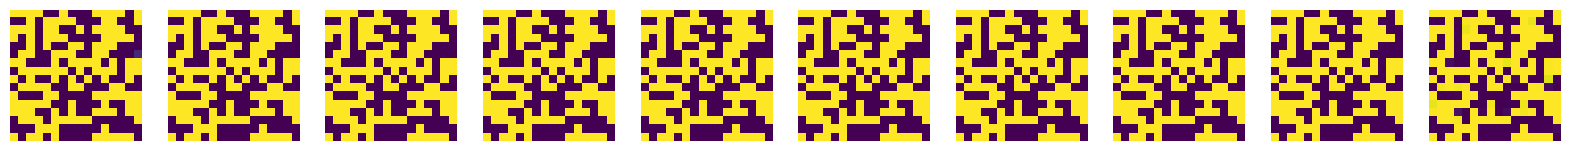

Epoch:    1 | Step: 1310 | Loss: 0.088772
Epoch:    1 | Step: 1320 | Loss: 0.106002
Epoch:    1 | Step: 1330 | Loss: 0.142053
Epoch:    1 | Step: 1340 | Loss: 0.161567
Epoch:    1 | Step: 1350 | Loss: 0.079010
Epoch:    1 | Step: 1360 | Loss: 0.112004
Epoch:    1 | Step: 1370 | Loss: 0.060276
Epoch:    1 | Step: 1380 | Loss: 0.092402
Epoch:    1 | Step: 1390 | Loss: 0.097467
Epoch:    1 | Step: 1400 | Loss: 0.060325


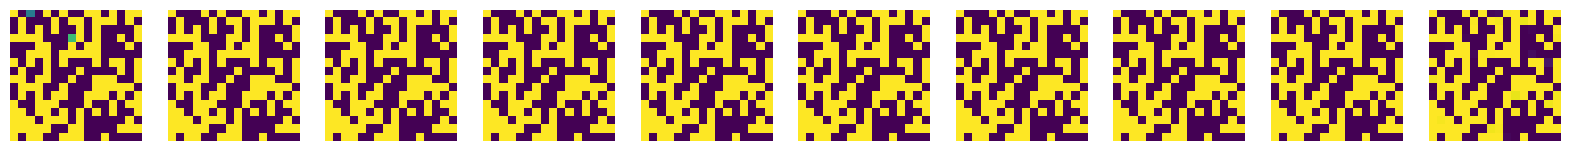

Epoch:    1 | Step: 1410 | Loss: 0.112172
Epoch:    1 | Step: 1420 | Loss: 0.131177
Epoch:    1 | Step: 1430 | Loss: 0.093353
Epoch:    1 | Step: 1440 | Loss: 0.114871
Epoch:    1 | Step: 1450 | Loss: 0.155090
Epoch:    1 | Step: 1460 | Loss: 0.130126
Epoch:    1 | Step: 1470 | Loss: 0.143454
Epoch:    1 | Step: 1480 | Loss: 0.072829
Epoch:    1 | Step: 1490 | Loss: 0.071828
Epoch:    1 | Step: 1500 | Loss: 0.060363


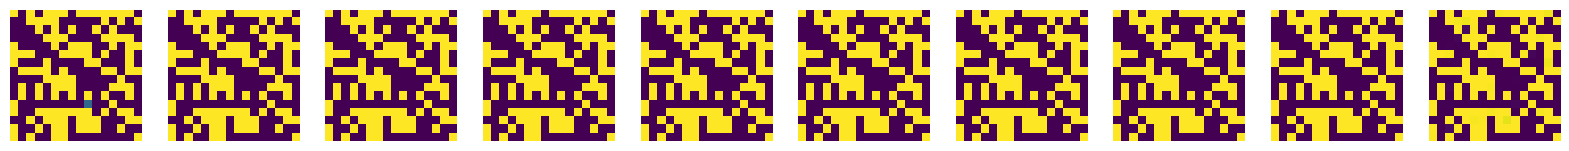

Epoch:    1 | Step: 1510 | Loss: 0.097717
Epoch:    1 | Step: 1520 | Loss: 0.080942
Epoch:    1 | Step: 1530 | Loss: 0.081030
Epoch:    1 | Step: 1540 | Loss: 0.086459
Epoch:    1 | Step: 1550 | Loss: 0.097914
Epoch:    1 | Step: 1560 | Loss: 0.056981
Epoch:    1 | Step: 1570 | Loss: 0.073186
Epoch:    1 | Step: 1580 | Loss: 0.059929
Epoch:    1 | Step: 1590 | Loss: 0.062809
Epoch:    1 | Step: 1600 | Loss: 0.147758


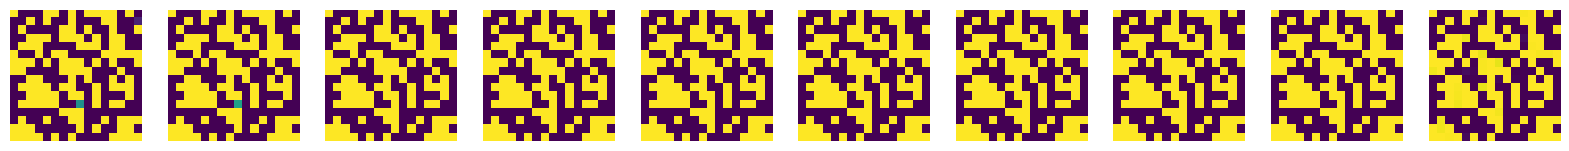

Epoch:    1 | Step: 1610 | Loss: 0.052652
Epoch:    1 | Step: 1620 | Loss: 0.063176
Epoch:    1 | Step: 1630 | Loss: 0.098558
Epoch:    1 | Step: 1640 | Loss: 0.091171
Epoch:    1 | Step: 1650 | Loss: 0.100582
Epoch:    1 | Step: 1660 | Loss: 0.080267
Epoch:    1 | Step: 1670 | Loss: 0.129103
Epoch:    1 | Step: 1680 | Loss: 0.099335
Epoch:    1 | Step: 1690 | Loss: 0.051850
Epoch:    1 | Step: 1700 | Loss: 0.069958


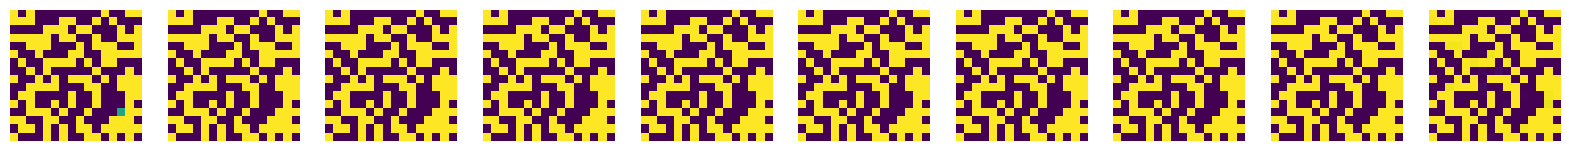

Epoch:    1 | Step: 1710 | Loss: 0.074488
Epoch:    1 | Step: 1720 | Loss: 0.095540
Epoch:    1 | Step: 1730 | Loss: 0.058143
Epoch:    1 | Step: 1740 | Loss: 0.088493
Epoch:    1 | Step: 1750 | Loss: 0.056659
Epoch:    1 | Step: 1760 | Loss: 0.061158
Epoch:    1 | Step: 1770 | Loss: 0.118197
Epoch:    1 | Step: 1780 | Loss: 0.093407
Epoch:    1 | Step: 1790 | Loss: 0.074091
Epoch:    1 | Step: 1800 | Loss: 0.066292


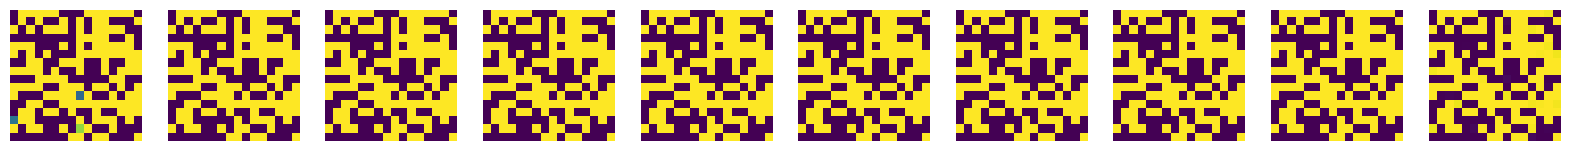

Epoch:    1 | Step: 1810 | Loss: 0.094271
Epoch:    1 | Step: 1820 | Loss: 0.049644
Epoch:    1 | Step: 1830 | Loss: 0.061175
Epoch:    1 | Step: 1840 | Loss: 0.063910
Epoch:    1 | Step: 1850 | Loss: 0.068894
Epoch:    1 | Step: 1860 | Loss: 0.090485
Epoch:    1 | Step: 1870 | Loss: 0.128946
Epoch:    1 | Step: 1880 | Loss: 0.061232
Epoch:    1 | Step: 1890 | Loss: 0.130832
Epoch:    1 | Step: 1900 | Loss: 0.083640


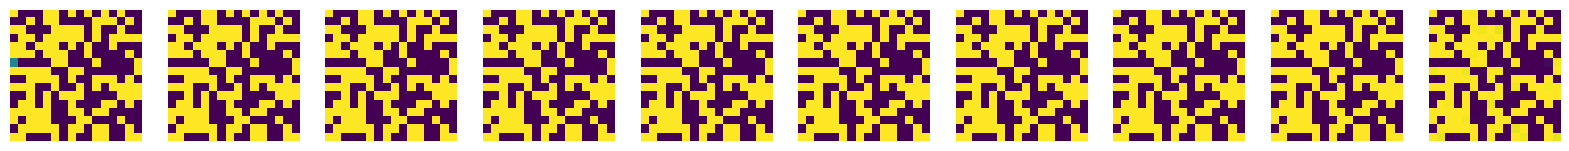

Epoch:    1 | Step: 1910 | Loss: 0.054742
Epoch:    1 | Step: 1920 | Loss: 0.082637
Epoch:    1 | Step: 1930 | Loss: 0.087529
Epoch:    1 | Step: 1940 | Loss: 0.084744
Epoch:    1 | Step: 1950 | Loss: 0.099095
Epoch:    1 | Step: 1960 | Loss: 0.093351
Epoch:    1 | Step: 1970 | Loss: 0.110664
Epoch:    1 | Step: 1980 | Loss: 0.071679
Epoch:    1 | Step: 1990 | Loss: 0.103295
Epoch:    1 | Step: 2000 | Loss: 0.119622


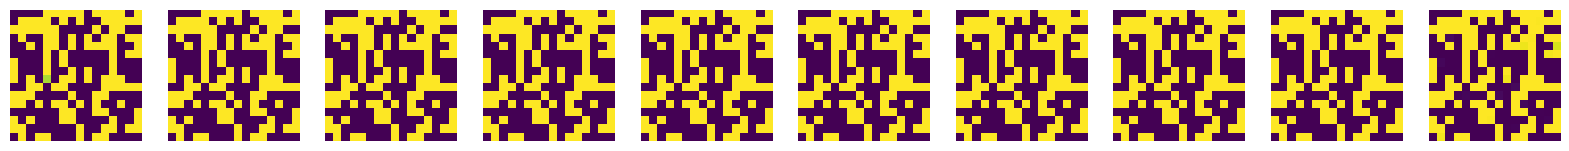

Epoch:    1 | Step: 2010 | Loss: 0.067005
Epoch:    1 | Step: 2020 | Loss: 0.094883
Epoch:    1 | Step: 2030 | Loss: 0.138252
Epoch:    1 | Step: 2040 | Loss: 0.059498
Epoch:    1 | Step: 2050 | Loss: 0.113221
Epoch:    1 | Step: 2060 | Loss: 0.049506
Epoch:    1 | Step: 2070 | Loss: 0.057145
Epoch:    1 | Step: 2080 | Loss: 0.070952
Epoch:    1 | Step: 2090 | Loss: 0.084363
Epoch:    1 | Step: 2100 | Loss: 0.058549


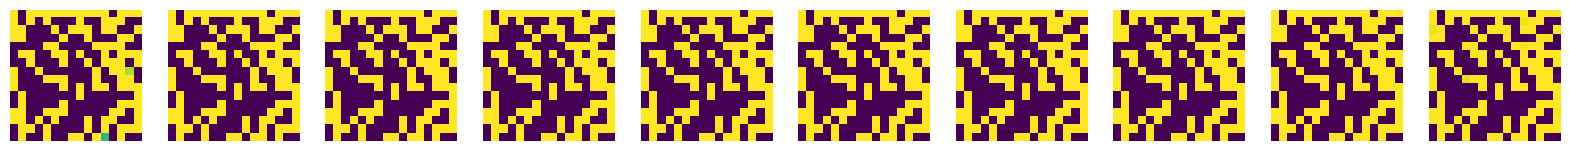

Epoch:    1 | Step: 2110 | Loss: 0.052245
Epoch:    1 | Step: 2120 | Loss: 0.066632
Epoch:    1 | Step: 2130 | Loss: 0.097567
Epoch:    1 | Step: 2140 | Loss: 0.113829
Epoch:    1 | Step: 2150 | Loss: 0.142576
Epoch:    1 | Step: 2160 | Loss: 0.076339
Epoch:    1 | Step: 2170 | Loss: 0.097995
Epoch:    1 | Step: 2180 | Loss: 0.095706
Epoch:    1 | Step: 2190 | Loss: 0.071665
Epoch:    1 | Step: 2200 | Loss: 0.060366


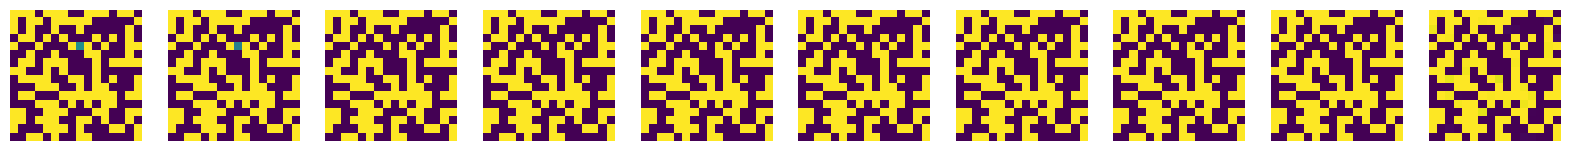

Epoch:    1 | Step: 2210 | Loss: 0.065277
Epoch:    1 | Step: 2220 | Loss: 0.100983
Epoch:    1 | Step: 2230 | Loss: 0.088284
Epoch:    1 | Step: 2240 | Loss: 0.087717
Epoch:    1 | Step: 2250 | Loss: 0.073701
Epoch:    1 | Step: 2260 | Loss: 0.078759
Epoch:    1 | Step: 2270 | Loss: 0.077806
Epoch:    1 | Step: 2280 | Loss: 0.080588
Epoch:    1 | Step: 2290 | Loss: 0.090688
Epoch:    1 | Step: 2300 | Loss: 0.066776


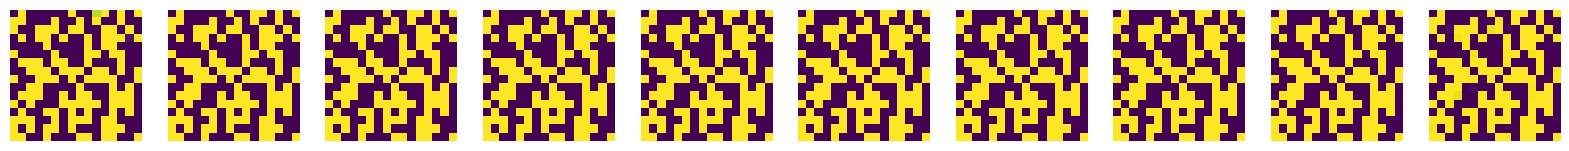

Epoch:    1 | Step: 2310 | Loss: 0.067534
Epoch:    1 | Step: 2320 | Loss: 0.101170
Epoch:    1 | Step: 2330 | Loss: 0.085077
Epoch:    1 | Step: 2340 | Loss: 0.052813
Epoch:    1 | Step: 2350 | Loss: 0.042374
Epoch:    1 | Step: 2360 | Loss: 0.095383
Epoch:    1 | Step: 2370 | Loss: 0.064813
Epoch:    1 | Step: 2380 | Loss: 0.045368
Epoch:    1 | Step: 2390 | Loss: 0.042295
Epoch:    1 | Step: 2400 | Loss: 0.070388


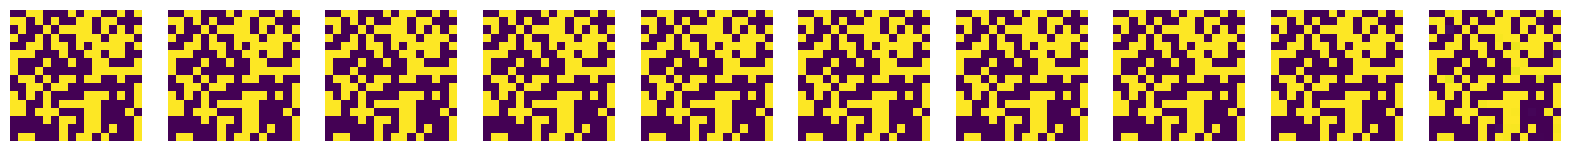

Epoch:    1 | Step: 2410 | Loss: 0.084289
Epoch:    1 | Step: 2420 | Loss: 0.090540
Epoch:    1 | Step: 2430 | Loss: 0.068053
Epoch:    1 | Step: 2440 | Loss: 0.077624
Epoch:    1 | Step: 2450 | Loss: 0.107561
Epoch:    1 | Step: 2460 | Loss: 0.061172
Epoch:    1 | Step: 2470 | Loss: 0.065413
Epoch:    1 | Step: 2480 | Loss: 0.054199
Epoch:    1 | Step: 2490 | Loss: 0.145243
Epoch:    1 | Step: 2500 | Loss: 0.050065


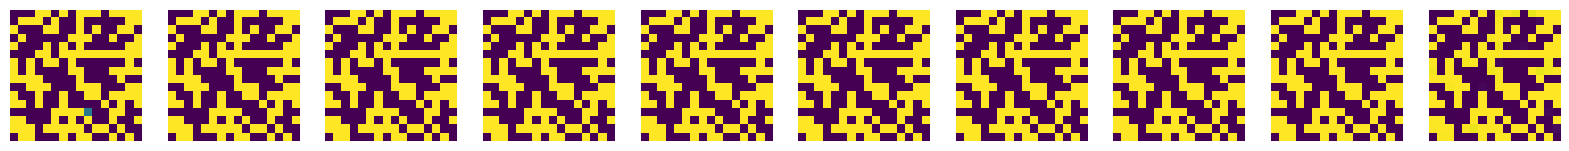

Epoch:    1 | Step: 2510 | Loss: 0.056252
Epoch:    1 | Step: 2520 | Loss: 0.074705
Epoch:    1 | Step: 2530 | Loss: 0.119692
Epoch:    1 | Step: 2540 | Loss: 0.050843
Epoch:    1 | Step: 2560 | Loss: 0.050270
Epoch:    1 | Step: 2570 | Loss: 0.104387
Epoch:    1 | Step: 2580 | Loss: 0.089800
Epoch:    1 | Step: 2590 | Loss: 0.110737
Epoch:    1 | Step: 2600 | Loss: 0.074319


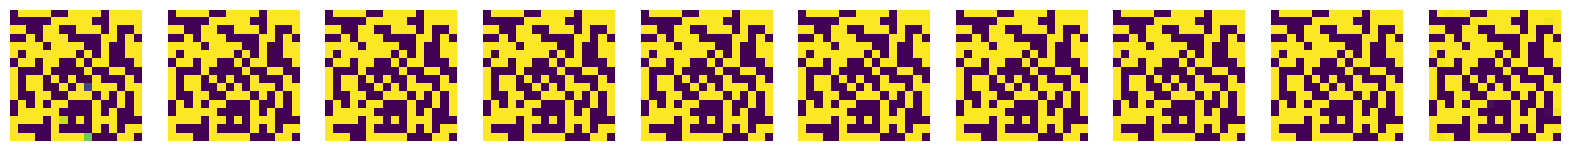

Epoch:    1 | Step: 2610 | Loss: 0.038379
Epoch:    1 | Step: 2620 | Loss: 0.054560
Epoch:    1 | Step: 2630 | Loss: 0.050143
Epoch:    1 | Step: 2640 | Loss: 0.057085
Epoch:    1 | Step: 2650 | Loss: 0.051075
Epoch:    1 | Step: 2660 | Loss: 0.049238
Epoch:    1 | Step: 2670 | Loss: 0.077616
Epoch:    1 | Step: 2680 | Loss: 0.160961
Epoch:    1 | Step: 2690 | Loss: 0.102420
Epoch:    1 | Step: 2700 | Loss: 0.117096


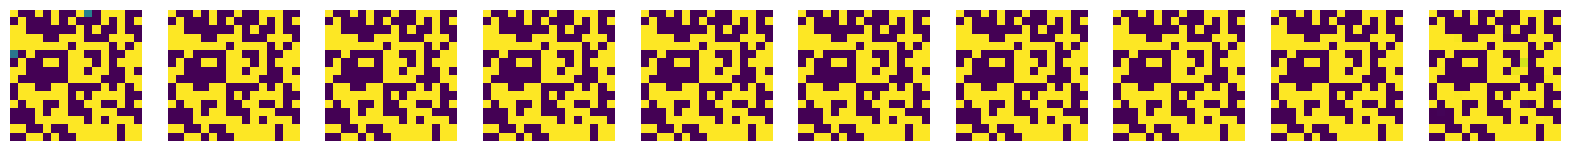

Epoch:    1 | Step: 2710 | Loss: 0.069565
Epoch:    1 | Step: 2720 | Loss: 0.064302
Epoch:    1 | Step: 2730 | Loss: 0.058644
Epoch:    1 | Step: 2740 | Loss: 0.061494
Epoch:    1 | Step: 2750 | Loss: 0.062105
Epoch:    1 | Step: 2760 | Loss: 0.067062
Epoch:    1 | Step: 2770 | Loss: 0.042894
Epoch:    1 | Step: 2780 | Loss: 0.078919
Epoch:    1 | Step: 2790 | Loss: 0.041084
Epoch:    1 | Step: 2800 | Loss: 0.046479


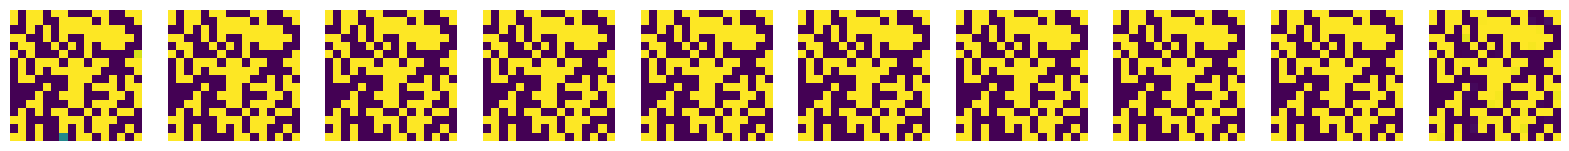

Epoch:    1 | Step: 2810 | Loss: 0.093318
Epoch:    1 | Step: 2820 | Loss: 0.048433
Epoch:    1 | Step: 2830 | Loss: 0.063522
Epoch:    1 | Step: 2840 | Loss: 0.076748
Epoch:    1 | Step: 2850 | Loss: 0.085084
Epoch:    1 | Step: 2860 | Loss: 0.062976
Epoch:    1 | Step: 2870 | Loss: 0.117565
Epoch:    1 | Step: 2880 | Loss: 0.089291
Epoch:    1 | Step: 2890 | Loss: 0.121298
Epoch:    1 | Step: 2900 | Loss: 0.154610


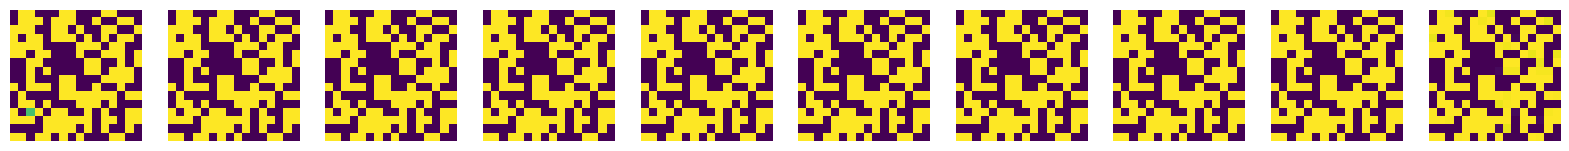

Epoch:    1 | Step: 2910 | Loss: 0.082060
Epoch:    1 | Step: 2920 | Loss: 0.074608
Epoch:    1 | Step: 2930 | Loss: 0.043243
Epoch:    1 | Step: 2940 | Loss: 0.062495
Epoch:    1 | Step: 2950 | Loss: 0.078914
Epoch:    1 | Step: 2960 | Loss: 0.080825
Epoch:    1 | Step: 2970 | Loss: 0.044677
Epoch:    1 | Step: 2980 | Loss: 0.091031
Epoch:    1 | Step: 2990 | Loss: 0.136404
Epoch:    1 | Step: 3000 | Loss: 0.108353


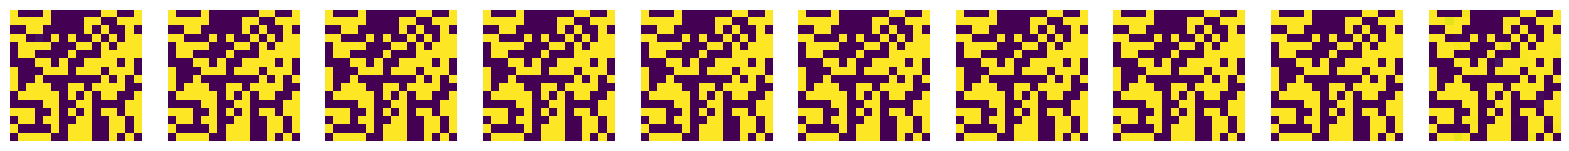

Epoch:    1 | Step: 3010 | Loss: 0.094776
Epoch:    1 | Step: 3020 | Loss: 0.068975
Epoch:    1 | Step: 3030 | Loss: 0.083035
Epoch:    1 | Step: 3040 | Loss: 0.067823
Epoch:    1 | Step: 3050 | Loss: 0.064893
Epoch:    1 | Step: 3060 | Loss: 0.111091
Epoch:    1 | Step: 3070 | Loss: 0.102425
Epoch:    1 | Step: 3080 | Loss: 0.068515
Epoch:    1 | Step: 3090 | Loss: 0.097544
Epoch:    1 | Step: 3100 | Loss: 0.093108


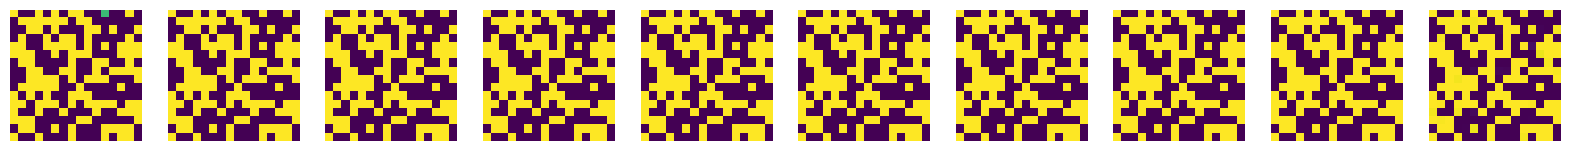

Epoch:    1 | Step: 3110 | Loss: 0.098672
Epoch:    1 | Step: 3120 | Loss: 0.077401
Epoch:    1 | Step: 3130 | Loss: 0.040521
Epoch:    1 | Step: 3140 | Loss: 0.065145
Epoch:    1 | Step: 3150 | Loss: 0.065236
Epoch:    1 | Step: 3160 | Loss: 0.047025
Epoch:    1 | Step: 3170 | Loss: 0.065704
Epoch:    1 | Step: 3180 | Loss: 0.060563
Epoch:    1 | Step: 3190 | Loss: 0.042959
Epoch:    1 | Step: 3200 | Loss: 0.044565


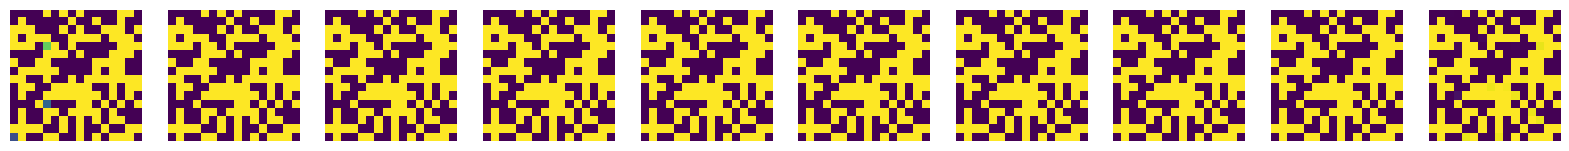

Epoch:    1 | Step: 3210 | Loss: 0.063961
Epoch:    1 | Step: 3220 | Loss: 0.070272
Epoch:    1 | Step: 3230 | Loss: 0.044474
Epoch:    1 | Step: 3240 | Loss: 0.058315
Epoch:    1 | Step: 3250 | Loss: 0.071654
Epoch:    1 | Step: 3260 | Loss: 0.073664
Epoch:    1 | Step: 3270 | Loss: 0.124707
Epoch:    1 | Step: 3280 | Loss: 0.049544
Epoch:    1 | Step: 3290 | Loss: 0.091643
Epoch:    1 | Step: 3300 | Loss: 0.098451


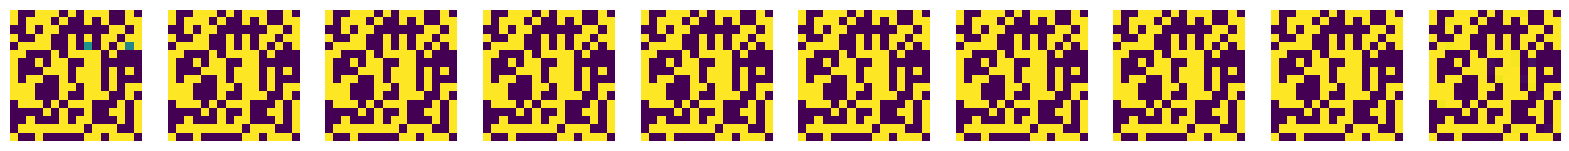

Epoch:    1 | Step: 3310 | Loss: 0.071863
Epoch:    1 | Step: 3320 | Loss: 0.070695
Epoch:    1 | Step: 3330 | Loss: 0.073983
Epoch:    1 | Step: 3340 | Loss: 0.151024
Epoch:    1 | Step: 3350 | Loss: 0.083630
Epoch:    1 | Step: 3360 | Loss: 0.094606
Epoch:    1 | Step: 3370 | Loss: 0.067337
Epoch:    1 | Step: 3380 | Loss: 0.046485
Epoch:    1 | Step: 3390 | Loss: 0.053011
Epoch:    1 | Step: 3400 | Loss: 0.052449


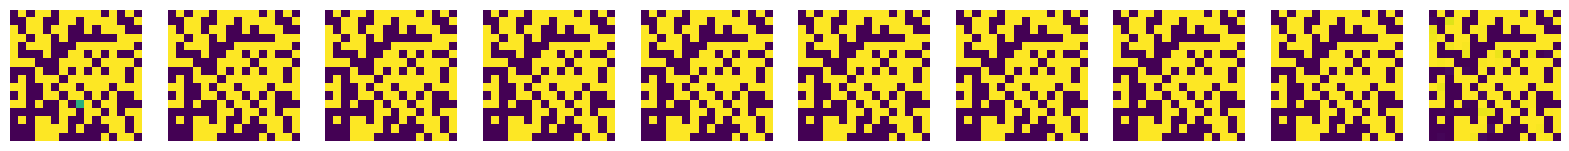

Epoch:    1 | Step: 3410 | Loss: 0.058342
Epoch:    1 | Step: 3420 | Loss: 0.088745
Epoch:    1 | Step: 3430 | Loss: 0.050210
Epoch:    1 | Step: 3440 | Loss: 0.039138
Epoch:    1 | Step: 3450 | Loss: 0.059729
Epoch:    1 | Step: 3460 | Loss: 0.089756
Epoch:    1 | Step: 3470 | Loss: 0.083883
Epoch:    1 | Step: 3480 | Loss: 0.091425
Epoch:    1 | Step: 3490 | Loss: 0.058206
Epoch:    1 | Step: 3500 | Loss: 0.085126


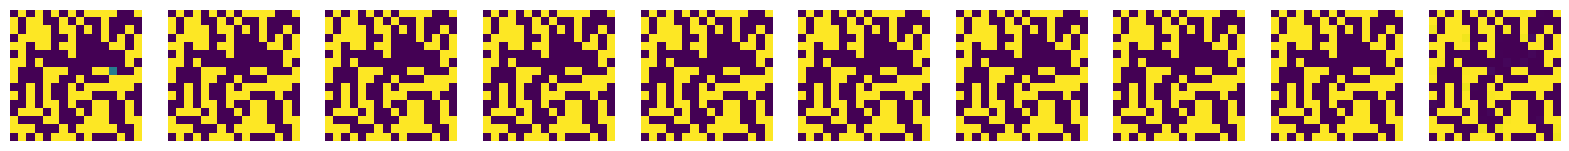

Epoch:    1 | Step: 3510 | Loss: 0.074009
Epoch:    1 | Step: 3520 | Loss: 0.048992
Epoch:    1 | Step: 3530 | Loss: 0.075203
Epoch:    1 | Step: 3540 | Loss: 0.055445
Epoch:    1 | Step: 3550 | Loss: 0.066896
Epoch:    1 | Step: 3560 | Loss: 0.066739
Epoch:    1 | Step: 3570 | Loss: 0.087510
Epoch:    1 | Step: 3580 | Loss: 0.056608
Epoch:    1 | Step: 3590 | Loss: 0.080236
Epoch:    1 | Step: 3600 | Loss: 0.073116


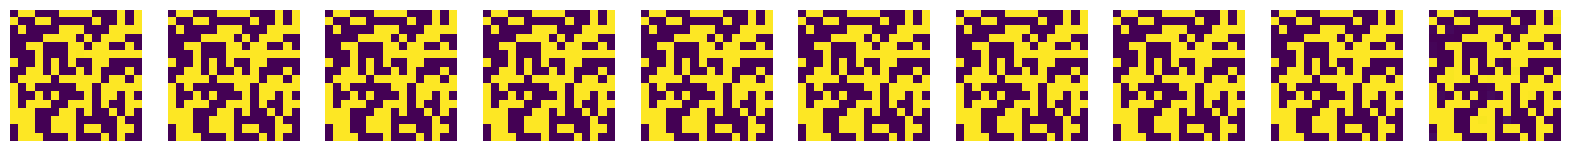

Epoch:    1 | Step: 3610 | Loss: 0.052236
Epoch:    1 | Step: 3620 | Loss: 0.087877
Epoch:    1 | Step: 3630 | Loss: 0.060149
Epoch:    1 | Step: 3640 | Loss: 0.103045
Epoch:    1 | Step: 3650 | Loss: 0.057682
Epoch:    1 | Step: 3660 | Loss: 0.063374
Epoch:    1 | Step: 3670 | Loss: 0.069020
Epoch:    1 | Step: 3680 | Loss: 0.049953
Epoch:    1 | Step: 3690 | Loss: 0.091188
Epoch:    1 | Step: 3700 | Loss: 0.139356


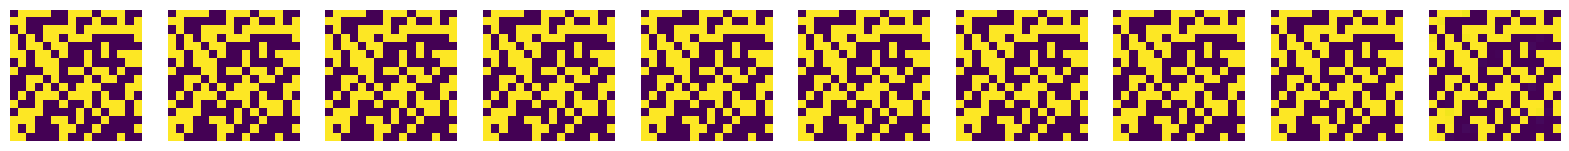

Epoch:    1 | Step: 3710 | Loss: 0.066354
Epoch:    1 | Step: 3720 | Loss: 0.088919
Epoch:    1 | Step: 3730 | Loss: 0.082863
Epoch:    1 | Step: 3740 | Loss: 0.047298
Epoch:    1 | Step: 3750 | Loss: 0.055965
Epoch:    1 | Step: 3760 | Loss: 0.080691
Epoch:    1 | Step: 3770 | Loss: 0.066994
Epoch:    1 | Step: 3780 | Loss: 0.065275
Epoch:    1 | Step: 3790 | Loss: 0.101195
Epoch:    1 | Step: 3800 | Loss: 0.078973


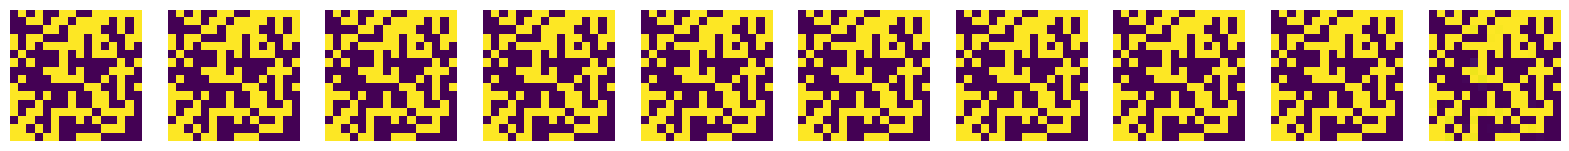

Epoch:    1 | Step: 3810 | Loss: 0.150450
Epoch:    1 | Step: 3820 | Loss: 0.085105
Epoch:    1 | Step: 3830 | Loss: 0.072678
Epoch:    1 | Step: 3840 | Loss: 0.060358
Epoch:    1 | Step: 3850 | Loss: 0.065607
Epoch:    1 | Step: 3860 | Loss: 0.049963
Epoch:    1 | Step: 3870 | Loss: 0.111089
Epoch:    1 | Step: 3880 | Loss: 0.060027
Epoch:    1 | Step: 3890 | Loss: 0.091320
Epoch:    1 | Step: 3900 | Loss: 0.065387


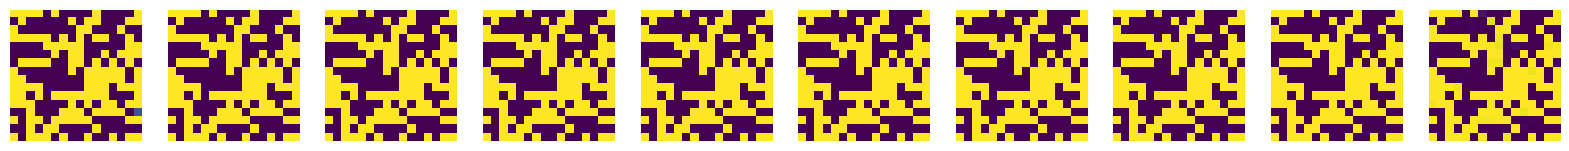

Epoch:    1 | Step: 3910 | Loss: 0.074535
Epoch:    1 | Step: 3920 | Loss: 0.050360
Epoch:    1 | Step: 3930 | Loss: 0.055335
Epoch:    1 | Step: 3940 | Loss: 0.097501
Epoch:    1 | Step: 3950 | Loss: 0.063436
Epoch:    1 | Step: 3960 | Loss: 0.069835
Epoch:    1 | Step: 3970 | Loss: 0.042532
Epoch:    1 | Step: 3980 | Loss: 0.044580
Epoch:    1 | Step: 3990 | Loss: 0.102621
Epoch:    1 | Step: 4000 | Loss: 0.054307


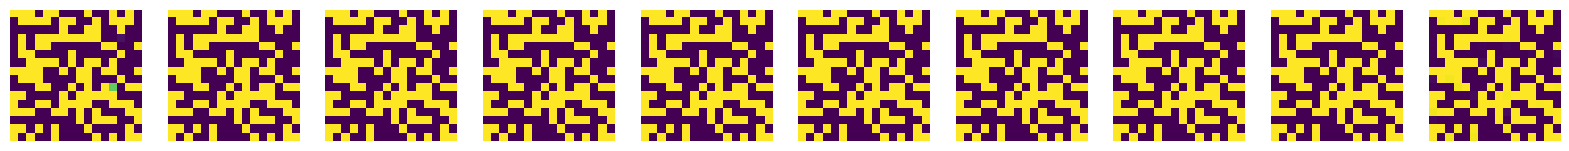

Epoch:    1 | Step: 4010 | Loss: 0.044430
Epoch:    1 | Step: 4020 | Loss: 0.075107
Epoch:    1 | Step: 4030 | Loss: 0.100907
Epoch:    1 | Step: 4040 | Loss: 0.056100
Epoch:    1 | Step: 4050 | Loss: 0.051755
Epoch:    1 | Step: 4060 | Loss: 0.072274
Epoch:    1 | Step: 4070 | Loss: 0.094628
Epoch:    1 | Step: 4080 | Loss: 0.029782
Epoch:    1 | Step: 4090 | Loss: 0.091615
Epoch:    1 | Step: 4100 | Loss: 0.061088


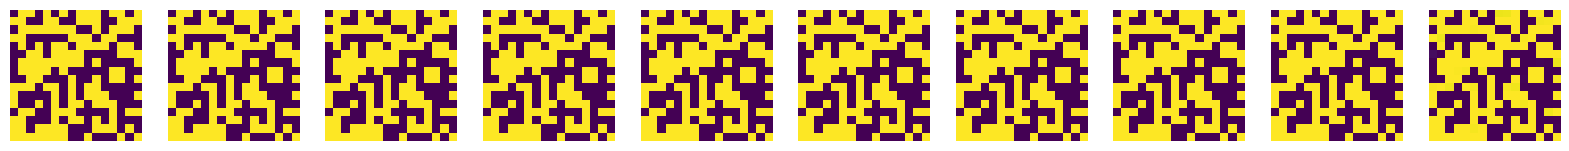

Epoch:    1 | Step: 4110 | Loss: 0.071913
Epoch:    1 | Step: 4120 | Loss: 0.069578
Epoch:    1 | Step: 4130 | Loss: 0.070964
Epoch:    1 | Step: 4140 | Loss: 0.069642
Epoch:    1 | Step: 4150 | Loss: 0.088152
Epoch:    1 | Step: 4160 | Loss: 0.039279
Epoch:    1 | Step: 4170 | Loss: 0.043788
Epoch:    1 | Step: 4180 | Loss: 0.075180
Epoch:    1 | Step: 4190 | Loss: 0.037348
Epoch:    1 | Step: 4200 | Loss: 0.049104


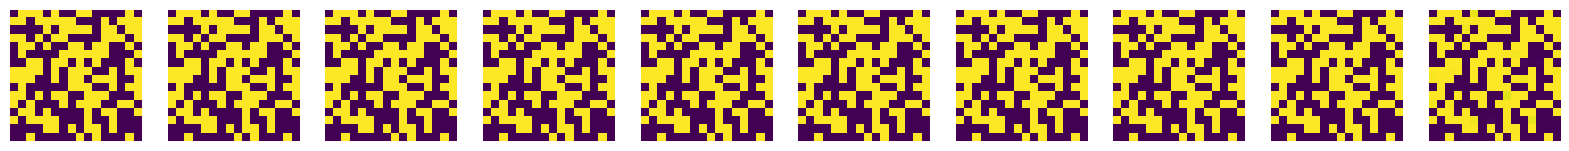

Epoch:    1 | Step: 4210 | Loss: 0.051089
Epoch:    1 | Step: 4220 | Loss: 0.063663
Epoch:    1 | Step: 4230 | Loss: 0.104408
Epoch:    1 | Step: 4240 | Loss: 0.054772
Epoch:    1 | Step: 4250 | Loss: 0.070775
Epoch:    1 | Step: 4260 | Loss: 0.057781
Epoch:    1 | Step: 4270 | Loss: 0.042207
Epoch:    1 | Step: 4280 | Loss: 0.040893
Epoch:    1 | Step: 4290 | Loss: 0.055926
Epoch:    1 | Step: 4300 | Loss: 0.051998


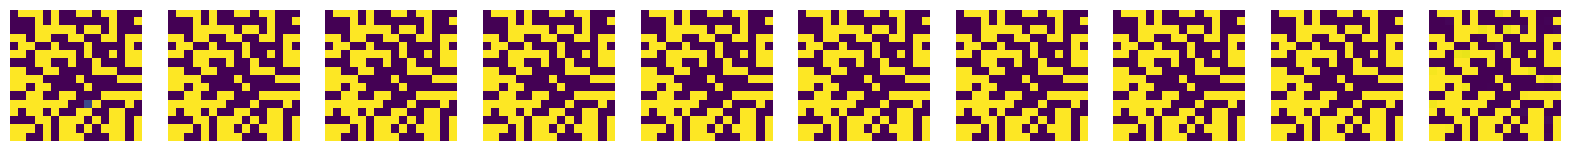

Epoch:    1 | Step: 4310 | Loss: 0.041580
Epoch:    1 | Step: 4320 | Loss: 0.045077
Epoch:    1 | Step: 4330 | Loss: 0.045595
Epoch:    1 | Step: 4340 | Loss: 0.063064
Epoch:    1 | Step: 4350 | Loss: 0.056762
Epoch:    1 | Step: 4360 | Loss: 0.057461
Epoch:    1 | Step: 4370 | Loss: 0.046721


In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

epochs = 1
losses = []
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        batch_images = batch[0]
        batch_labels = batch[1]

        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE, ), device=device, dtype=torch.long)
        loss = calculate_loss(model, batch_images, t)
        loss.backward()

        optimizer.step()
        if ((step+1) % 10 == 0):
          print(f'Epoch: {epoch+1:4d} | Step: {step+1:4d} | Loss: {loss.item():.6f}')
        if ((step+1) % 100 == 0):
          sample_image()
        losses.append(loss.item())

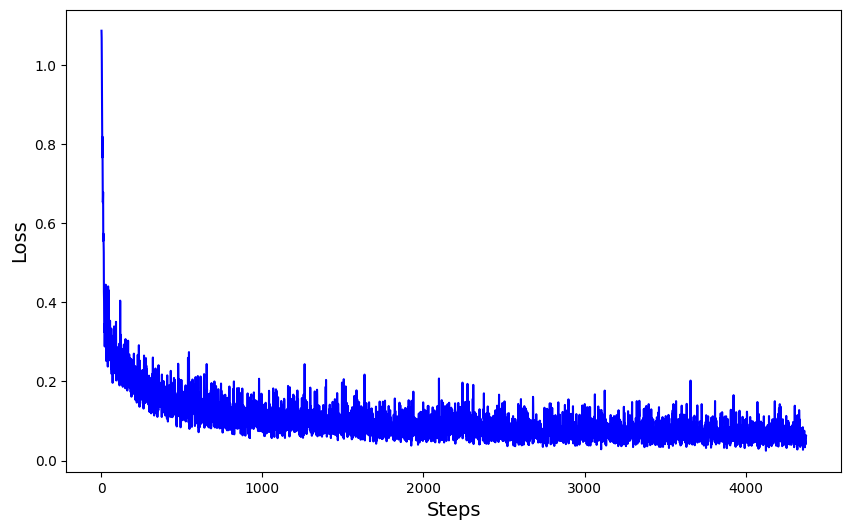

In [22]:
steps = range(1, len(losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(steps, losses, color='blue')
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.show()

In [23]:
dataset_name = 'MNIST_model.pth'
if not os.path.exists('./models'):
    os.makedirs('./models')

model_path = f'./models/{dataset_name}'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to ./models/MNIST_model.pth
